# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [77]:
# import libraries

import datetime
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, lit, col, desc, current_date, datediff, count
from pyspark.sql.functions import sum as sum_
from pyspark.sql.functions import max as max_
from pyspark.sql.functions import round as round_
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
# create a Spark session

spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
dfRaw = spark.read.json('mini_sparkify_event_data.json')

In [4]:
dfRaw.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
dfRaw.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
dfRaw.describe("userId").show()
dfRaw.describe("sessionId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [7]:
print(f'# of null userIds: {dfRaw.filter(dfRaw.userId.isNull()).count()}')
print(f'# of null sessionIds: {dfRaw.filter(dfRaw.sessionId.isNull()).count()}')

# of null userIds: 0
# of null sessionIds: 0


In [8]:
print(f'# of empty userIds: {dfRaw.filter(dfRaw.userId == "").count()}')
print(f'# of empty sessionIds: {dfRaw.filter(dfRaw.sessionId == "").count()}')

# of empty userIds: 8346
# of empty sessionIds: 0


In [9]:
emptyUserId = dfRaw.filter(dfRaw.userId == "")

In [10]:
dfRaw.groupby(dfRaw.auth).count().show()
emptyUserId.groupby(emptyUserId.auth).count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [11]:
dfRaw.groupby(dfRaw.page).count().show()
emptyUserId.groupby(emptyUserId.page).count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 rows

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|Submit Registration|    5|
|              Login| 3241|
|           Register|   18|
|               Help|  272|
| 

In [12]:
validUsers = dfRaw.filter(dfRaw.userId != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))

In [14]:
validUsers = validUsers.withColumn("hour", get_hour(validUsers.ts).cast("float"))
validUsers = validUsers.withColumn("date", get_date(validUsers.ts))

In [15]:
churnUsers = validUsers.filter(validUsers.page == 'Cancellation Confirmation').select('userId')
churnUsers = churnUsers.withColumn("churn", lit(1))
churnUsers=churnUsers.select(col("userId").alias("userId_a"), col("churn"))

validUsers = validUsers.join(churnUsers, validUsers.userId == churnUsers.userId_a, 'left')
validUsers = validUsers.drop(validUsers.userId_a)

In [16]:
downUsers = validUsers.filter(validUsers.page == 'Submit Downgrade').select('userId')
downUsers = downUsers.withColumn("downgrade", lit(1))
downUsers=downUsers.select(col("userId").alias("userId_b"), col("downgrade"))

validUsers = validUsers.join(downUsers, validUsers.userId == downUsers.userId_b, 'left')
validUsers = validUsers.drop(validUsers.userId_b)

In [17]:
churnedDf = validUsers.filter(validUsers.churn == 1).select(['userId','gender','page','hour','date', 'downgrade','level','ts','registration'])
nChurnedDf = validUsers.filter(validUsers.churn.isNull()).select(['userId','gender','page','hour','date', 'downgrade','level','ts','registration'])

### Analise de musicas

In [18]:
churnedSongs = churnedDf.filter(churnedDf.page == 'NextSong')
nChurnedSongs = nChurnedDf.filter(nChurnedDf.page == 'NextSong')

In [19]:
numUsersChurn = churnUsers.count()
numUsersNChurn = nChurnedSongs.select(nChurnedSongs.userId).dropDuplicates().count()

In [20]:
# média de musicas por usuario que churn
churnedSongs.count() / numUsersChurn

699.8846153846154

In [21]:
# média de musicas por usuario que não churn
nChurnedSongs.count() / numUsersNChurn

1365.2890173410406

#### Analise de churned por data

In [22]:
songByDay = churnedSongs.groupby(churnedSongs.date).count().orderBy(churnedSongs.date).select(col("date").alias("date_a"), col("count").alias("qtdSongs"))
userByDay = churnedSongs.select(['date','userId']).dropDuplicates().groupby(churnedSongs.date).count().orderBy(churnedSongs.date).select(col("date").alias("date_b"), col("count").alias("qtdUsers"))

In [23]:
songsByUserDay = songByDay.join(userByDay, songByDay.date_a == userByDay.date_b, 'left').orderBy(songByDay.date_a)
songsByUserDay = songsByUserDay.withColumn("songs_user", songsByUserDay.qtdSongs/songsByUserDay.qtdUsers).drop(songsByUserDay.date_b)

In [24]:
pdSongsDayChurn = songsByUserDay.toPandas()

In [25]:
pdSongsDayChurn.head()

,date_a,qtdSongs,qtdUsers,songs_user
0,2018-10-01,870,18,48.333333
1,2018-10-02,1431,19,75.315789
2,2018-10-03,1307,21,62.238095
3,2018-10-04,1157,20,57.850000
4,2018-10-05,1329,18,73.833333


In [26]:
pdSongsDayChurn[['date_a','qtdSongs']].plot.line(figsize=(15,5))

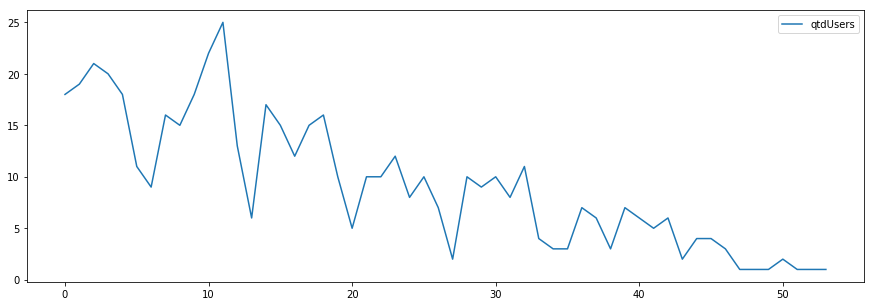

In [27]:
pdSongsDayChurn[['date_a','qtdUsers']].plot.line(figsize=(15,5))

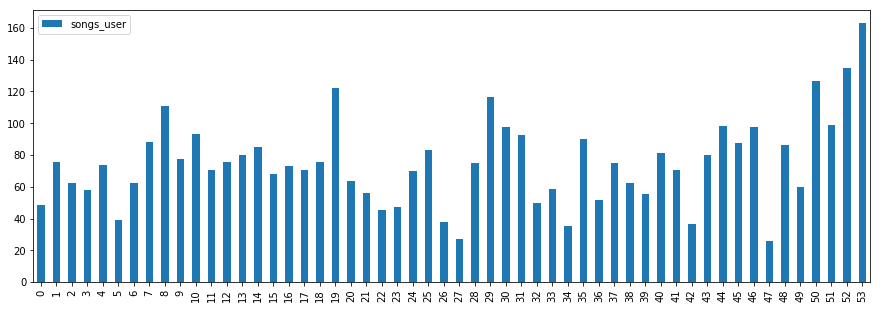

In [28]:
pdSongsDayChurn[['date_a','songs_user']].plot.bar(figsize=(15,5))

#### Analise de não churned por data

In [29]:
songByDay = nChurnedSongs.groupby(nChurnedSongs.date).count().orderBy(nChurnedSongs.date).select(col("date").alias("date_a"), col("count").alias("qtdSongs"))
userByDay = nChurnedSongs.select(['date','userId']).dropDuplicates().groupby(nChurnedSongs.date).count().orderBy(nChurnedSongs.date).select(col("date").alias("date_b"), col("count").alias("qtdUsers"))

In [30]:
songsByUserDay = songByDay.join(userByDay, songByDay.date_a == userByDay.date_b, 'left').orderBy(songByDay.date_a)
songsByUserDay = songsByUserDay.withColumn("songs_user", songsByUserDay.qtdSongs/songsByUserDay.qtdUsers).drop(songsByUserDay.date_b)

In [31]:
pdSongsDayNChurn = songsByUserDay.toPandas()

In [32]:
pdSongsDayNChurn.head()

,date_a,qtdSongs,qtdUsers,songs_user
0,2018-10-01,3070,47,65.319149
1,2018-10-02,2606,36,72.388889
2,2018-10-03,2157,44,49.022727
3,2018-10-04,2918,46,63.434783
4,2018-10-05,2656,44,60.363636


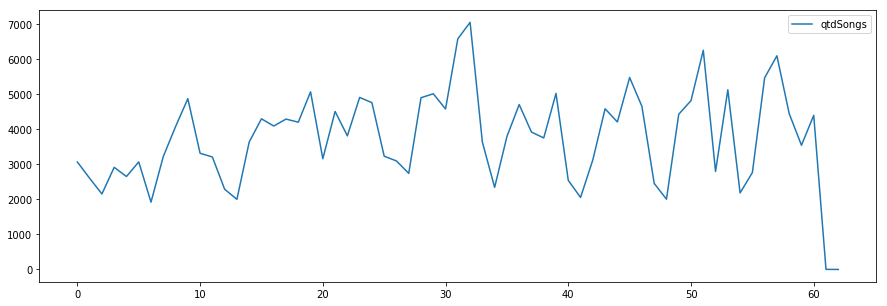

In [33]:
pdSongsDayNChurn[['date_a','qtdSongs']].plot.line(figsize=(15,5))

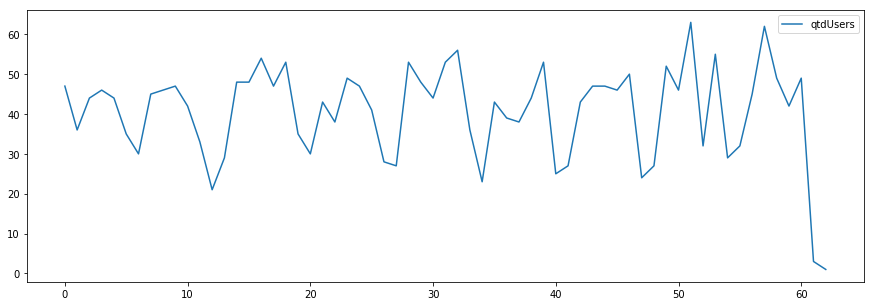

In [34]:
pdSongsDayNChurn[['date_a','qtdUsers']].plot.line(figsize=(15,5))

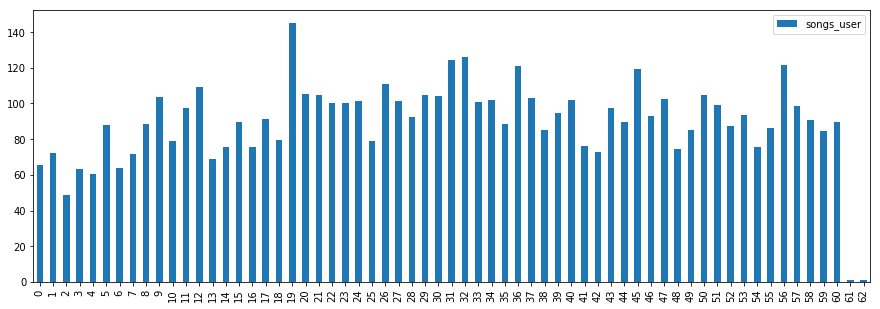

In [35]:
pdSongsDayNChurn[['date_a','songs_user']].plot.bar(figsize=(15,5))

#### Analise de churned por hora

In [36]:
songByHour = churnedSongs.groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_a"), col("count").alias("qtdSongs"))
userByHour = churnedSongs.select(['hour','userId']).dropDuplicates().groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_b"), col("count").alias("qtdUsers"))

In [37]:
songsByUserHour = songByHour.join(userByHour, songByHour.hour_a == userByHour.hour_b, 'left').orderBy(songByHour.hour_a)
songsByUserHour = songsByUserHour.withColumn("songs_user", songsByUserHour.qtdSongs/songsByUserHour.qtdUsers).drop(songsByUserHour.hour_b)

In [38]:
pdSongsHourChurn = songsByUserHour.toPandas()

In [39]:
pdSongsHourChurn.head()

,hour_a,qtdSongs,qtdUsers,songs_user
0,0.0,1535,36,42.638889
1,1.0,1353,34,39.794118
2,2.0,1322,36,36.722222
3,3.0,1292,32,40.375000
4,4.0,1233,35,35.228571


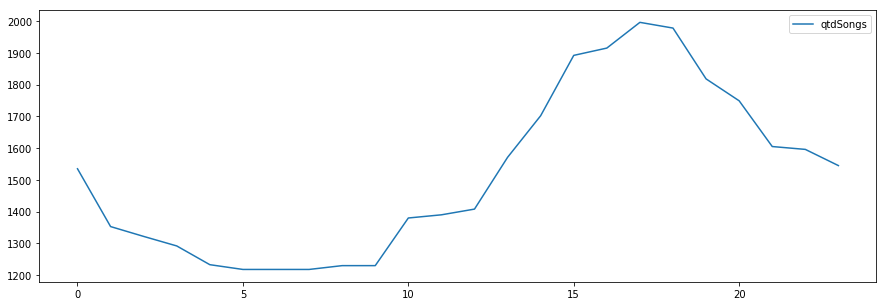

In [40]:
pdSongsHourChurn[['qtdSongs']].plot.line(figsize=(15,5))

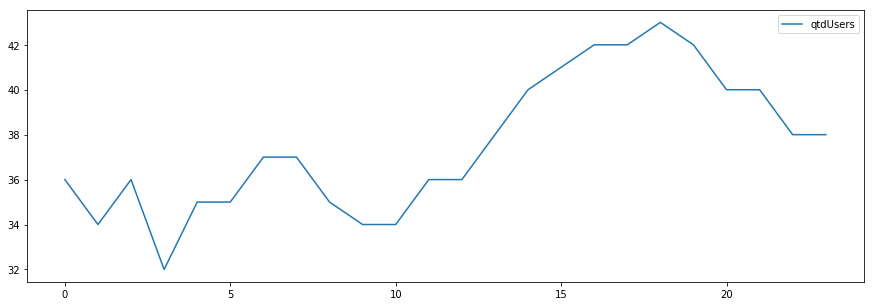

In [41]:
pdSongsHourChurn[['qtdUsers']].plot.line(figsize=(15,5))

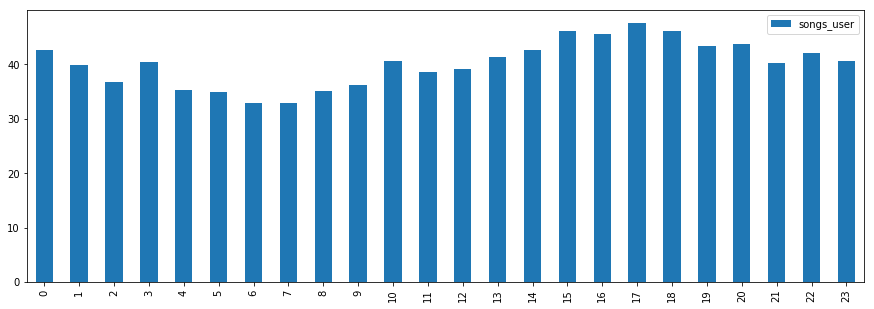

In [42]:
pdSongsHourChurn[['songs_user']].plot.bar(figsize=(15,5))

#### Analise de nao churned por hora

In [43]:
songByHour = nChurnedSongs.groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_a"), col("count").alias("qtdSongs"))
userByHour = nChurnedSongs.select(['hour','userId']).dropDuplicates().groupby(churnedSongs.hour).count().orderBy(churnedSongs.hour).select(col("hour").alias("hour_b"), col("count").alias("qtdUsers"))

In [44]:
songsByUserHour = songByHour.join(userByHour, songByHour.hour_a == userByHour.hour_b, 'left').orderBy(songByHour.hour_a)
songsByUserHour = songsByUserHour.withColumn("songs_user", songsByUserHour.qtdSongs/songsByUserHour.qtdUsers).drop(songsByUserHour.hour_b)

In [45]:
pdSongsHourNChurn = songsByUserHour.toPandas()

In [46]:
pdSongsHourNChurn.head()

,hour_a,qtdSongs,qtdUsers,songs_user
0,0.0,9181,137,67.014599
1,1.0,8679,138,62.891304
2,2.0,8626,140,61.614286
3,3.0,8714,139,62.690647
4,4.0,8512,137,62.131387


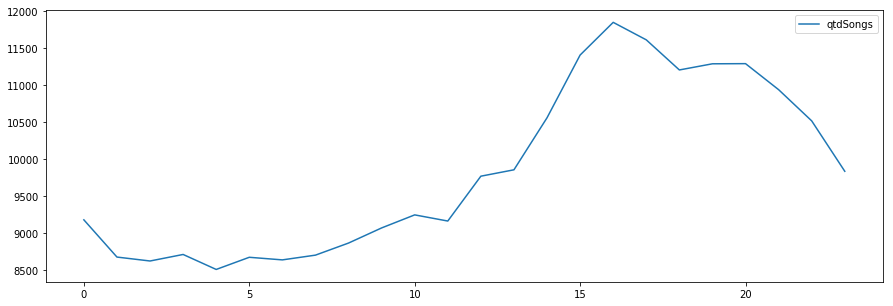

In [47]:
pdSongsHourNChurn[['qtdSongs']].plot.line(figsize=(15,5))

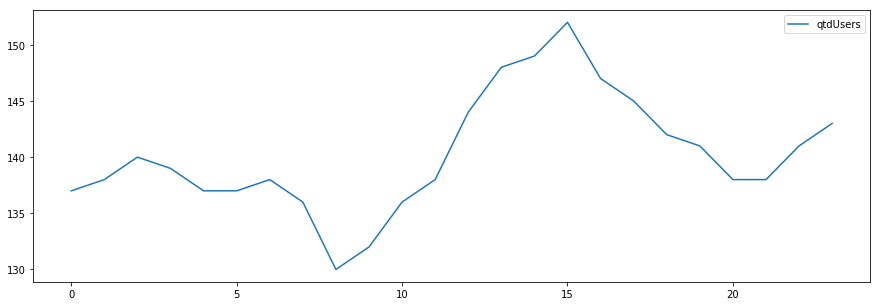

In [48]:
pdSongsHourNChurn[['qtdUsers']].plot.line(figsize=(15,5))

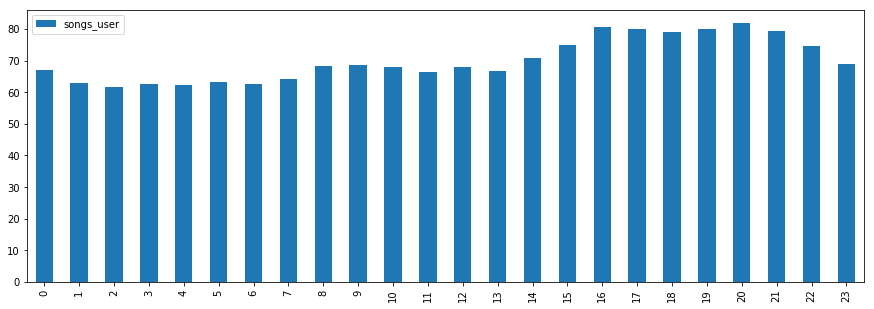

In [49]:
pdSongsHourNChurn[['songs_user']].plot.bar(figsize=(15,5))

#### Analise de Thumbs Up/Down

In [50]:
churnedTU = churnedDf.filter(churnedDf.page == 'Thumbs Up')
nChurnedTU = nChurnedDf.filter(nChurnedDf.page == 'Thumbs Up')

churnedTD = churnedDf.filter(churnedDf.page == 'Thumbs Down')
nChurnedTD = nChurnedDf.filter(nChurnedDf.page == 'Thumbs Down')

In [51]:
# média de likes por usuario que churn
churnedTU.count() / numUsersChurn

35.75

In [52]:
# média de likes por usuario que nao churn
nChurnedTU.count() / numUsersNChurn

74.44508670520231

In [53]:
# média de dislikes por usuario que churn
churnedTD.count() / numUsersChurn

9.538461538461538

In [54]:
# média de dislikes por usuario que nao churn
nChurnedTD.count() / numUsersNChurn

14.878612716763005

In [55]:
# média de likes por musica de usuarios churn
churnedTU.count() / churnedSongs.count()

0.05107984832664725

In [56]:
# média de likes por musica de usuarios nao churn
nChurnedTU.count() / nChurnedSongs.count()

0.05452697982599124

In [57]:
# média de dislikes por musica de usuarios churn
churnedTD.count() / churnedSongs.count()

0.013628620102214651

In [58]:
# média de dislikes por musica de usuarios nao churn
nChurnedTD.count() / nChurnedSongs.count()

0.010897775143419632

#### Analise de level

In [59]:
numChurnedLevel = churnedDf.filter(churnedDf.page == 'Cancellation Confirmation').groupby(churnedDf.level).count()
numChurnedLevel.show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [60]:
numChurnedLevelDown = churnedDf.filter(churnedDf.page == 'Cancellation Confirmation').filter(churnedDf.level=='free').agg(sum_(churnedDf.downgrade))
numChurnedLevelDown.show()

+--------------+
|sum(downgrade)|
+--------------+
|             5|
+--------------+



In [61]:
# 60% dos usuários que cancelaram eram pagos e se considerar os que eram pagos mas fizeram downgrade sobe para 70%

#### Analise de tempo de registro

In [62]:
churnedReg = churnedDf.groupBy(churnedDf.userId, churnedDf.registration).agg(max_(churnedDf.date))
churnedReg = churnedReg.withColumn("regDate", get_date(churnedReg.registration))
churnedReg = churnedReg.withColumn("dateDiff", datediff(col('max(date)'),col('regDate')))
churnedReg = churnedReg.select(churnedReg.userId,churnedReg.dateDiff)
pdChurnedReg = churnedReg.toPandas()

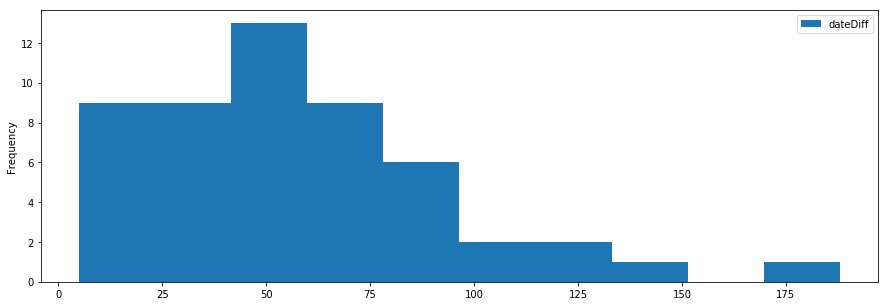

In [63]:
pdChurnedReg[['dateDiff']].plot.hist(figsize=(15,5))

In [64]:
nChurnedReg = nChurnedDf.groupBy(churnedDf.userId, churnedDf.registration).agg(max_(churnedDf.date))
nChurnedReg = nChurnedReg.withColumn("regDate", get_date(nChurnedReg.registration))
nChurnedReg = nChurnedReg.withColumn("dateDiff", datediff(col('max(date)'),col('regDate')))
nChurnedReg = nChurnedReg.select(nChurnedReg.userId,nChurnedReg.dateDiff)
pdNChurnedReg = nChurnedReg.toPandas()

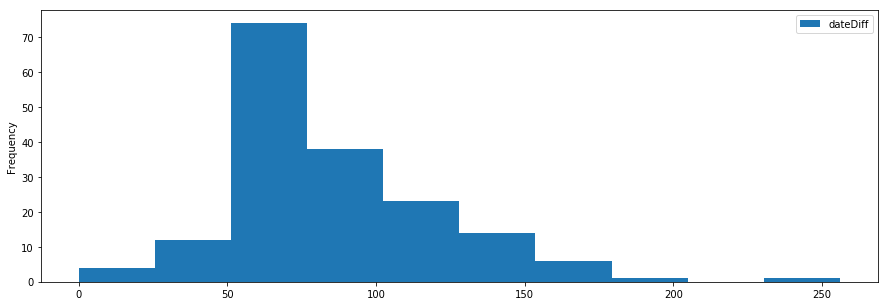

In [65]:
pdNChurnedReg[['dateDiff']].plot.hist(figsize=(15,5))

#### Analise de amigos

In [66]:
churnedDf.filter(churnedDf.page=='Add Friend').count()/numUsersChurn

12.23076923076923

In [67]:
nChurnedDf.filter(nChurnedDf.page=='Add Friend').count()/numUsersNChurn

25.959537572254334

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [68]:
def prepare_dataset(df):
    """
    Prepare the data to be able to run in the model.
    After cleaning, the following attributes are created for each user:
        songs: number of songs listened to by the user
        avgThumbsDown: Average user thumbs down per song
        level: most current user level (1=paid and 0=free)
        downgrade: flag if the user has downgraded
        dateDiffReg: difference in days between last user interaction and registration date
        friends: number of friends on the platform
        churn: class that identifies whether user churn or not
        
    input: df - raw dataframe os sparkify use
    
    output: dataframe of features to be used in model
    
    """
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))
    get_level = udf(lambda x: 1 if x == 'paid' else 0)
    
    validUsers = df.filter(dfRaw.userId != "")
    validUsers = validUsers.withColumn("date", get_date(validUsers.ts))

    numSongs = validUsers.filter(validUsers.page == 'NextSong').groupBy(validUsers.userId).agg(count(validUsers.page))
    numSongs = numSongs.select(col('userId'),col('count(page)').alias('songs'))

    numThumbsDown = validUsers.filter(churnedDf.page == 'Thumbs Down').groupBy(validUsers.userId).agg(count(validUsers.page))
    numThumbsDown = numThumbsDown.select(col('userId'),col('count(page)').alias('thumbsDown'))

    lastIteraction = validUsers.groupBy(validUsers.userId).agg(max_(validUsers.ts))
    lastIteraction = lastIteraction.select(col('userId'), col('max(ts)').alias('ts'))
    lastIteraction = lastIteraction.join(validUsers, ['userId','ts'], 'left')

    lastLevel = lastIteraction.select(lastIteraction.userId, lastIteraction.level).dropDuplicates()
    lastLevel = lastLevel.withColumn("level", get_level(lastLevel.level).cast(IntegerType()))

#     downgrade = validUsers.select(validUsers.userId, validUsers.downgrade).dropDuplicates().fillna(0)
    downgrade = validUsers.filter(validUsers.page == 'Submit Downgrade').select('userId').dropDuplicates()
    downgrade = downgrade.withColumn("downgrade", lit(1))

    daysReg = validUsers.groupBy(validUsers.userId, validUsers.registration).agg(max_(validUsers.date))
    daysReg = daysReg.withColumn('regDate', get_date(daysReg.registration))
    daysReg = daysReg.withColumn('dateDiffReg', datediff(col('max(date)'),col('regDate')))
    daysReg = daysReg.select(daysReg.userId, daysReg.dateDiffReg)

    numFriends = validUsers.filter(validUsers.page=='Add Friend').groupBy(validUsers.userId).agg(count(validUsers.page))
    numFriends = numFriends.select(col('userId'),col('count(page)').alias('friends'))

    final = numSongs.join(numThumbsDown, ['userId'], 'left')
    final = final.withColumn('avgThumbsDown', round_(final.thumbsDown/final.songs,5))
    final = final.join(lastLevel, ['userId'], 'left')
    final = final.join(downgrade, ['userId'], 'left')
    final = final.join(daysReg, ['userId'], 'left')
    final = final.join(numFriends, ['userId'], 'left')
    final = final.join(churnUsers, final.userId == churnUsers.userId_a, 'left')

    final = final.drop(final.thumbsDown)
    final = final.drop(final.userId_a)
    final = final.fillna(0)

    return final

In [69]:
dfSparkify = prepare_dataset(dfRaw)

In [70]:
dfSparkify.show(5)

+------+-----+-------------+-----+---------+-----------+-------+-----+
|userId|songs|avgThumbsDown|level|downgrade|dateDiffReg|friends|churn|
+------+-----+-------------+-----+---------+-----------+-------+-----+
|100010|  275|      0.01818|    0|        0|         55|      4|    0|
|200002|  387|       0.0155|    1|        0|         70|      4|    0|
|   125|    8|          0.0|    0|        0|         72|      0|    1|
|   124| 4079|      0.01005|    1|        0|        131|     74|    0|
|    51| 2111|      0.00995|    1|        0|         20|     28|    1|
+------+-----+-------------+-----+---------+-----------+-------+-----+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [71]:
def scale_features(df):
    """
    Transform coluns into features using VectorAssembler and StandartScale.
    
    input: df - prepeared dataframe of sparkify users.
    
    output: dataframe with scaled features and a label 
    
    """
    
    ls_features = df.columns[1:-1]
    
    assembler = VectorAssembler(inputCols=ls_features, outputCol='features', handleInvalid = 'skip')
    dfVector = assembler.transform(dfSparkify)
    
    scaler = StandardScaler(inputCol='features', outputCol='sc_features', withMean=True, withStd=True)
    scaler_fit = scaler.fit(dfVector) 
    
    df_result = scaler_fit.transform(dfVector)
    
    return df_result.select(df_result.sc_features.alias('features'), df_result.churn.alias('label'))
    

In [72]:
train, test = scale_features(dfSparkify).randomSplit([0.8, 0.2], seed=42)

In [91]:
def evaluate_model(result):
    """
    Returns Accuracy and F1 score of the predicted dataset
    
    input: result - predicted dataset
    
    outputs: accuracy - accuracy of the predicted dataset
             f1 - F1 score of the predicted dataset
    
    """
    
    # Evaluation
    eval_accuracy = MulticlassClassificationEvaluator(metricName='accuracy')
    eval_f1 = MulticlassClassificationEvaluator(metricName='f1')

    accuracy = eval_accuracy.evaluate(result.select(result.label, result.prediction))
    f1 = eval_f1.evaluate(result.select(result.label, result.prediction))
    
    return accuracy, f1
    

In [92]:
def test_evaluate_models(train, test):
    """
    Fits and evaluate models and prints the evaluation results.
    
    inputs: 
        train - train dataframe
        test - test dataframe    
    
    """
    
    lsModels = [LogisticRegression(), RandomForestClassifier(), GBTClassifier()]
    
    for ml in lsModels:
          
        model = ml.fit(train)
        predict = model.transform(test)

        accuracy, f1 = evaluate_model(predict)

        print(f'==== {ml.__class__.__name__} ====')
        print(f'   Accuracy: {accuracy}')
        print(f'   F1 score: {f1}')
        print('')
    

In [93]:
test_evaluate_models(train, test)

==== LogisticRegression ====
   Accuracy: 0.7941176470588235
   F1 score: 0.7517893870835047

==== RandomForestClassifier ====
   Accuracy: 0.8823529411764706
   F1 score: 0.8721719457013575

==== GBTClassifier ====
   Accuracy: 0.6176470588235294
   F1 score: 0.5719570847206807



In [97]:
def tune_model(ml, train, test):
    """
    Uses the ParamGridBuilder and CrossValidator to tune the LogisticRegression model with the best parameters.
    
    inputs: 
        train - train dataframe
        test - test dataframe
    
    """
    if ml == 'LogisticRegression':
        
        model = LogisticRegression()

        paramGrid = ParamGridBuilder() \
                    .addGrid(model.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
                    .addGrid(model.regParam,[0.0, 0.05, 0.1]) \
                    .build()
    elif ml == 'RandomForestClassifier':
        
        model = RandomForestClassifier()
    
        paramGrid = ParamGridBuilder() \
                 .addGrid(rf.maxDepth, [2, 5, 10, 25]) \
                 .addGrid(rf.maxBins, [10, 20, 50, 100]) \
                 .addGrid(rf.numTrees, [5, 20, 50, 100]) \
                 .build()
    else:
        print('Model not found. Try LogisticRegression or RandomForestClassifier')

    
    crossval = CrossValidator(estimator = model,
                              estimatorParamMaps = paramGrid,
                              evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                              numFolds = 3)

    cvModel = crossval.fit(train)
    bestModel = cvModel.bestModel
    
    print(f'==== {model.__class__.__name__} avgMetrics ====')
    print(cvModel.avgMetrics)
    
    prediction = cvModel.transform(test)
    
    lr_accuracy, lr_f1 = evaluate_model(prediction)
    print(f'---- Tuned {model.__class__.__name__} ----')
    print(f'   Accuracy: {lr_accuracy}')
    print(f'   F1 score: {lr_f1}')
    
    return bestModel

In [ ]:
bestLR = tune_model('LogisticRegression', train, test)

In [ ]:
bestRF = tune_model('RandomForestClassifier', train, test)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.